# **<center>Using CNN to stopping the car when it comes off the road<center>**
    
In this notebook, you can download images obtained with the donkey car. You can use them to launch a training in order to get a model for the donkey car.
Several options are available :

- The number of image to learn from
- The possibility to invert them to also learn turning right
    
    

In [1]:
import json
import shutil
import random
import pathlib
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as display

import mlflow
import mlflow.tensorflow
import mlflow.keras

import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import MSLE, MAE, MSE
from tensorflow.keras.losses import MSE, MSLE
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

from xebikart.images import transformer as T
import xebikart.dataset as dataset

%matplotlib inline

using donkey version: 2.5.8 ...


In [2]:
tf.__version__

'1.14.0'

In [3]:
tf.test.is_gpu_available()

False

Eager Execution allows to evaluate operations immediately without building graphs
note : Only needed when not using TF 2.0

In [4]:
tf.enable_eager_execution()

In [71]:
# parameters
# dataset parameters
tubes_root_folder = 'file:/workspace/xebikart-ml-tubes'
tubes_folders_exit = ["tub.v7.01", "tub.v7.02"]
tubes_folders_road = ["tub.v5.01", "tub.v5.02", "tub.v4.01", "tub.v4.02"]#, "tub.v5.03", "tub.v5.04"]

test_size=0.2

# training parameters
batch_size = 32
shuffle_size = 200
n_epochs = 50
learning_rate = 1e-4
decay = 1e-3

# Load data

Download tubes from : https://github.com/xebia-france/xebikart-ml-tubes

In [72]:
%%capture
road_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders_road, tubes_extension=".tar.gz")
road_tubes_df['label'] = 0
exit_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders_exit, tubes_extension=".tar.gz")
exit_tubes_df['label'] = 1
road_tubes_df = road_tubes_df.rename(columns={"cam/image_array": "images_path"})
exit_tubes_df = exit_tubes_df.rename(columns={"cam/image_array": "images_path"})
tubes_df = pd.concat([road_tubes_df, exit_tubes_df]).reset_index(drop=True)
tubes_df = tubes_df.drop(["user/angle", "user/throttle", "user/mode", "timestamp"], axis=1)

In [73]:
tubes_df.head()

,images_path,label,num_tube
0,/root/.keras/datasets/tub.v5.01/0_cam-image_ar...,0,0
1,/root/.keras/datasets/tub.v5.01/1_cam-image_ar...,0,0
2,/root/.keras/datasets/tub.v5.01/2_cam-image_ar...,0,0
3,/root/.keras/datasets/tub.v5.01/3_cam-image_ar...,0,0
4,/root/.keras/datasets/tub.v5.01/4_cam-image_ar...,0,0


#### **- Display some examples**

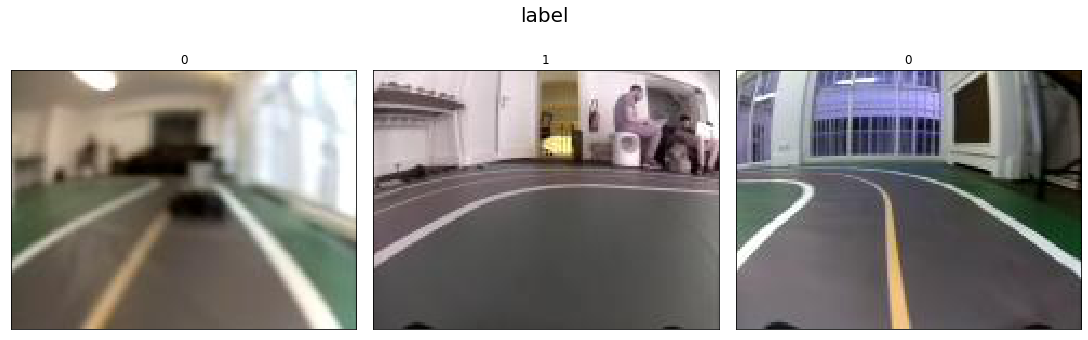

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True)
fig.suptitle("label", fontsize=20)

for n, sample in tubes_df.sample(3).reset_index().iterrows():
    random_image_path = sample["images_path"]
    label = sample["label"]
    image = mpimg.imread(random_image_path) 
    axs[n].set_title(label)
    axs[n].imshow(image)
    axs[n].get_xaxis().set_visible(False)
    axs[n].get_yaxis().set_visible(False)

#### **- Display some sample distribution**

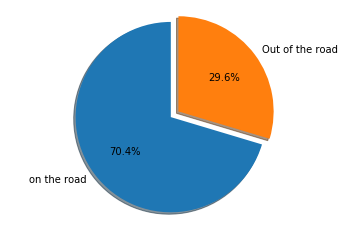

In [75]:
labels = 'on the road', 'Out of the road'
sizes = [len(tubes_df[tubes_df.label == 0]), len(tubes_df[tubes_df.label == 1])]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Preprocessing Images

In [76]:
crop_fn = T.generate_crop_fn(left_margin=30, width=80, height_margin=80, height=30)

def load_augmentation_preprocess(image_path):
    tf_image = T.read_image(image_path)
    tf_image = T.normalize(tf_image)
    #tf_image = tf.image.rgb_to_grayscale(tf_image)
    tf_image = crop_fn(tf_image)
    return tf_image

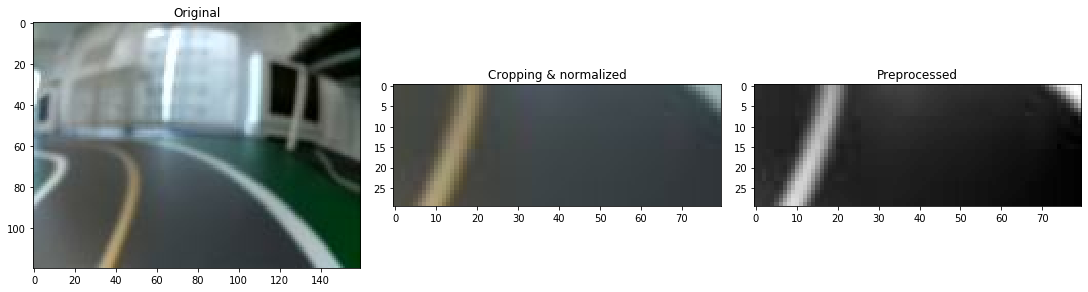

In [77]:
random_image_path = tubes_df.sample()["images_path"].values[0]

tf_image_original   = T.read_image(random_image_path)
tf_image_normalized = T.normalize(tf_image_original)
tf_image_cropped    = crop_fn(tf_image_normalized)
tf_image_grayscaled = tf.image.rgb_to_grayscale(tf_image_cropped)

fig, axs = plt.subplots(1, 3, figsize=(15,15), constrained_layout=True)
axs[0].set_title("Original")
axs[0].imshow(tf_image_original)
axs[1].set_title("Cropping & normalized")
axs[1].imshow(tf_image_cropped)
axs[2].set_title("Preprocessed")
axs[2].imshow(tf_image_grayscaled[:,:,0],cmap='gray')
plt.show()

# Build a dataset of images

#### **- Split data into test/train datasets**

Note : We only use angle as label

In [78]:
images_path = tubes_df["images_path"].tolist()
label = tubes_df["label"].tolist()

In [79]:
train_images_path, test_images_path, train_metas, test_metas = train_test_split(images_path, label, test_size=test_size)
print('Train set :', len(train_images_path), 'images')
print('Test set :', len(test_images_path), 'images')

Train set : 10312 images
Test set : 2578 images


#### **- Create tensor for train and test datasets**

In [80]:
def input_fn(filepath, label, BATCH_SIZE = 32, SHUFFLE_SIZE = 200, NUM_EPOCHS = 50):
    ds_x = tf.data.Dataset.from_tensor_slices(filepath)
    ds_x = ds_x.map(load_augmentation_preprocess)
    ds_y = tf.data.Dataset.from_tensor_slices(label)
    ds_x_y = tf.data.Dataset.zip((ds_x, ds_y)).shuffle(SHUFFLE_SIZE).repeat(NUM_EPOCHS).batch(BATCH_SIZE).prefetch(1)
    
    return ds_x_y

In [81]:
ds_train = input_fn(train_images_path, train_metas)
ds_test = input_fn(test_images_path, test_metas, NUM_EPOCHS=1)

# Build Model

In [82]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(30, 80, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 78, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 39, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 18, 32)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               884992    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

In [83]:
model.compile(optimizer=Adam(learning_rate=learning_rate, decay=learning_rate/n_epochs), loss="binary_crossentropy")

In [84]:
mlflow.set_experiment("detect_road_exit")

with mlflow.start_run():
    mlflow.log_params({
        "images_exit": str(tubes_folders_exit),
        "images_road": str(tubes_folders_road),
        "nb_images": len(train_images_path),
        "epochs": n_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    })
    mlflow.tensorflow.autolog()
    history = model.fit(x=ds_train,
                    steps_per_epoch=len(train_metas)//batch_size,
                    epochs=n_epochs,
                    verbose=1,
                    validation_data=ds_test,
                    validation_steps=len(test_metas)//batch_size)

Epoch 1/50
322/322 [==============================] - 9s 29ms/step - loss: 0.3526 - val_loss: 0.2094
Epoch 2/50
322/322 [==============================] - 9s 27ms/step - loss: 0.1815 - val_loss: 0.1538
Epoch 3/50
322/322 [==============================] - 9s 28ms/step - loss: 0.1402 - val_loss: 0.1216
Epoch 4/50
322/322 [==============================] - 9s 27ms/step - loss: 0.1106 - val_loss: 0.0924
Epoch 5/50
322/322 [==============================] - 9s 27ms/step - loss: 0.0931 - val_loss: 0.0766
Epoch 6/50
322/322 [==============================] - 9s 27ms/step - loss: 0.0780 - val_loss: 0.0637
Epoch 7/50
322/322 [==============================] - 9s 27ms/step - loss: 0.0684 - val_loss: 0.0548
Epoch 8/50
322/322 [==============================] - 9s 27ms/step - loss: 0.0592 - val_loss: 0.0734
Epoch 9/50
322/322 [==============================] - 9s 29ms/step - loss: 0.0528 - val_loss: 0.0426
Epoch 10/50
322/322 [==============================] - 9s 28ms/step - loss: 0.0495 - val_lo

# Plot loss

In [85]:
model.evaluate(ds_test)

81/81 [==============================] - 2s 20ms/step - loss: 0.0158


0.01578769084503788

In [88]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=['loss','val_loss']
    hist_df.index = np.arange(1, len(hist_df)+1)
    fig = plt.figure(figsize=(10,5))
    plt.plot(hist_df.val_loss, lw=3, label='Validation Loss')
    plt.plot(hist_df.loss, lw=3, label='Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc=0)

    plt.show()

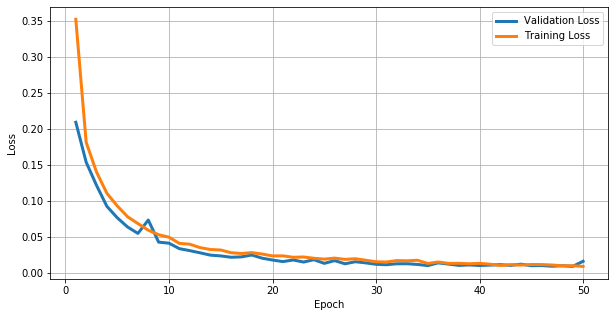

In [89]:
plot_results(history)

# Evaluation & Visualisation

### - Prediction

In [90]:
test_pred = model.predict(ds_test, use_multiprocessing=True, workers=12, steps = None)#len(test_metas)/batch_size)

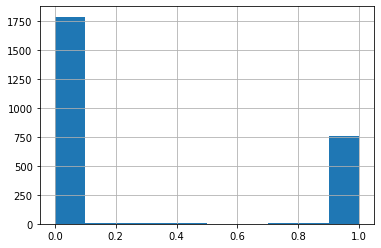

In [91]:
df = pd.DataFrame(test_pred, columns = ['label'])
df.label.hist()

### - Visualisation predictions

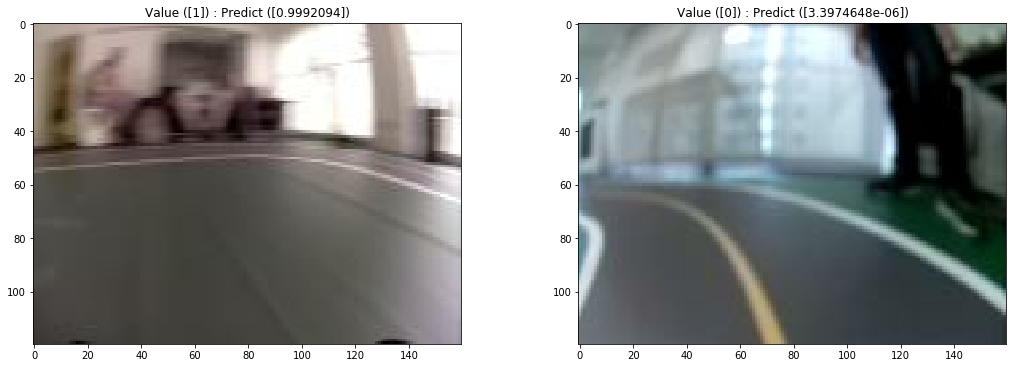

In [92]:
nb_random = np.random.randint(len(test_metas))

random_image_path_0 = [(test_images_path[nb_random])]
random_image_label_0 = [test_metas[nb_random]]

ds_visu_test_0 = input_fn(random_image_path_0, random_image_label_0)

nb_random = np.random.randint(len(test_metas))

random_image_path_1 = [(test_images_path[nb_random])]
random_image_label_1 = [test_metas[nb_random]]

ds_visu_test_1 = input_fn(random_image_path_1, random_image_label_1)

fig, axs = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
axs[0].set_title("Value ({}) : Predict ({})".format(random_image_label_0, model.predict(ds_visu_test_0)[0]))
axs[0].imshow(T.read_image(random_image_path_0[0]))
axs[1].set_title("Value ({}) : Predict ({})".format(random_image_label_1, model.predict(ds_visu_test_1)[0]))
axs[1].imshow(T.read_image(random_image_path_1[0]))

plt.show()

### - Interpretation results

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true=test_metas, probas_pred=test_pred)

In [ ]:
plt.plot(thresholds, precision[:-1], '--', label='precision')
plt.plot(thresholds, recall[:-1], '--', label='recall')
plt.xlabel('threshold')
plt.legend()

plt.show()

In [188]:
from tensorflow.keras.models import load_model
from tensorflow.compat.v2 import lite

In [189]:
def interpreter_and_details(model_path) :

    # Load TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path = model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape']

In [200]:
def predictor_builder(interpreter, input_details, output_details, input_shape):
    def predictor(input_image):
        interpreter.set_tensor(input_details[0]['index'], input_image)
        interpreter.invoke()

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        return output_data[0][0]
    return predictor

In [201]:
model = 'model_vae_2534loss'

In [202]:
%%capture
vae_model = load_model(model + '.h5', compile=False)
vae_model.compile(optimizer="adam", loss="binary_crossentropy")
vae_model.save(model + "_modified.h5", include_optimizer=False)
converter = lite.TFLiteConverter.from_keras_model(vae_model)

In [203]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                      tf.lite.OpsSet.SELECT_TF_OPS]
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.inference_type = tf.lite.constants.QUANTIZED_UINT8
#converter.representative_dataset = images_dataset___

tflite_model = converter.convert()

INFO:tensorflow:Converted 18 variables to const ops.


ConverterError: TOCO failed. See console for info.
2019-09-30 16:33:41.323139: I tensorflow/lite/toco/import_tensorflow.cc:1336] Converting unsupported operation: RandomStandardNormal
2019-09-30 16:33:41.335947: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Removing unused ops: 70 operators, 141 arrays (0 quantized)
2019-09-30 16:33:41.336604: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before general graph transformations: 70 operators, 141 arrays (0 quantized)
2019-09-30 16:33:41.340031: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 1: 45 operators, 109 arrays (0 quantized)
2019-09-30 16:33:41.429647: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 2: 44 operators, 108 arrays (0 quantized)
2019-09-30 16:33:41.431132: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 3: 40 operators, 100 arrays (0 quantized)
2019-09-30 16:33:41.432312: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Group bidirectional sequence lstm/rnn: 40 operators, 100 arrays (0 quantized)
2019-09-30 16:33:41.432929: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before dequantization graph transformations: 40 operators, 100 arrays (0 quantized)
2019-09-30 16:33:41.434187: I tensorflow/lite/toco/allocate_transient_arrays.cc:345] Total transient array allocated size: 614400 bytes, theoretical optimal value: 614400 bytes.
2019-09-30 16:33:41.435113: E tensorflow/lite/toco/toco_tooling.cc:456] We are continually in the process of adding support to TensorFlow Lite for more ops. It would be helpful if you could inform us of how this conversion went by opening a github issue at https://github.com/tensorflow/tensorflow/issues/new?template=40-tflite-op-request.md
 and pasting the following:

Some of the operators in the model are not supported by the standard TensorFlow Lite runtime. If those are native TensorFlow operators, you might be able to use the extended runtime by passing --enable_select_tf_ops, or by setting target_ops=TFLITE_BUILTINS,SELECT_TF_OPS when calling tf.lite.TFLiteConverter(). Otherwise, if you have a custom implementation for them you can disable this error with --allow_custom_ops, or by setting allow_custom_ops=True when calling tf.lite.TFLiteConverter(). Here is a list of builtin operators you are using: ADD, CONV_2D, EXP, FULLY_CONNECTED, LOGISTIC, MUL, PACK, RESHAPE, SHAPE, STRIDED_SLICE, TRANSPOSE_CONV. Here is a list of operators for which you will need custom implementations: RandomStandardNormal.
Traceback (most recent call last):
  File "/usr/local/bin/toco_from_protos", line 10, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 59, in main
    app.run(main=execute, argv=[sys.argv[0]] + unparsed)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python3.6/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.6/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.6/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 33, in execute
    output_str = tensorflow_wrap_toco.TocoConvert(model_str, toco_str, input_str)
Exception: We are continually in the process of adding support to TensorFlow Lite for more ops. It would be helpful if you could inform us of how this conversion went by opening a github issue at https://github.com/tensorflow/tensorflow/issues/new?template=40-tflite-op-request.md
 and pasting the following:

Some of the operators in the model are not supported by the standard TensorFlow Lite runtime. If those are native TensorFlow operators, you might be able to use the extended runtime by passing --enable_select_tf_ops, or by setting target_ops=TFLITE_BUILTINS,SELECT_TF_OPS when calling tf.lite.TFLiteConverter(). Otherwise, if you have a custom implementation for them you can disable this error with --allow_custom_ops, or by setting allow_custom_ops=True when calling tf.lite.TFLiteConverter(). Here is a list of builtin operators you are using: ADD, CONV_2D, EXP, FULLY_CONNECTED, LOGISTIC, MUL, PACK, RESHAPE, SHAPE, STRIDED_SLICE, TRANSPOSE_CONV. Here is a list of operators for which you will need custom implementations: RandomStandardNormal.




In [169]:
open("{}.tflite".format(model), "wb").write(tflite_model)

8664624

In [170]:
interpreter, input_details, output_details, input_shape = interpreter_and_details(model_path=model + ".tflite")

TypeError: allocate_tensors() missing 1 required positional argument: 'self'

In [132]:
predictor = predictor_builder(interpreter, input_details, output_details, input_shape)

NameError: name 'interpreter' is not defined